Assuming that the true physical mechanism at this time is the one where damage only <font color=red>by caused by instantaneous intensity</font>, hypothetical experiments to test component properties can be indirectly implemented by setting parameters in the cumulative fatigue damage theory. 

For example, setting $a=0$ eliminates cumulative fatigue damage, degenerating the model to only instantaneous intensity-induced damage.

In [1]:
import numpy as np
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

with open("fragility_experiments_data1.pkl", 'rb') as file:
    dataset = pickle.loads(file.read())
    fragility_only_ins = dataset["fragility_only_ins"]

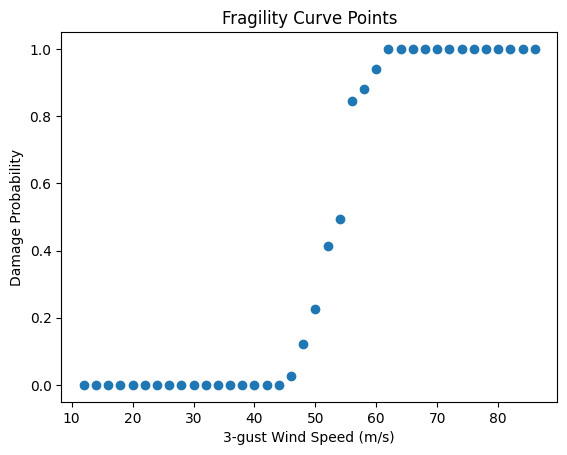

In [2]:
tradition_fragility = [(key, np.mean(fragility_only_ins[key])) 
                        for key in fragility_only_ins.keys()]
tradition_fragility = np.array(tradition_fragility)
plt.scatter(tradition_fragility[:, 0],
            tradition_fragility[:, 1],
            marker='o')
plt.title("Fragility Curve Points")
plt.xlabel('3-gust Wind Speed (m/s)')
plt.ylabel('Damage Probability')
plt.show()

In [3]:
def lognormal_cdf(x, mu, sigma):
    return norm.cdf((np.log(x) - mu) / sigma)

x = [key for key in fragility_only_ins.keys()]
y = [np.mean(fragility_only_ins[key]) for key in fragility_only_ins.keys()]

x = np.asarray(x)
y = np.asarray(y)
mask = x > 0
x_filtered = x[mask]
y_filtered = y[mask]
epsilon = 1e-6
y_filtered = np.clip(y_filtered, epsilon, 1 - epsilon)

# Step 1: Initial parameter estimation using linear regression
z = norm.ppf(y_filtered)
ln_x = np.log(x_filtered)
coeffs = np.polyfit(z, ln_x, 1)
sigma_initial, mu_initial = coeffs[0], coeffs[1]

# Step 2: Parameter optimization via nonlinear fitting (scipy.optimize.curve_fit)
p0 = [mu_initial, sigma_initial]
params, _ = curve_fit(lognormal_cdf, x_filtered, y_filtered, p0=p0)
mu_fit, sigma_fit = params

# Print the fitting result
print(f"Fitting Result: mu = {mu_fit:.8f}, sigma = {sigma_fit:.8f}")

Fitting Result: mu = 3.97126543, sigma = 0.07535683


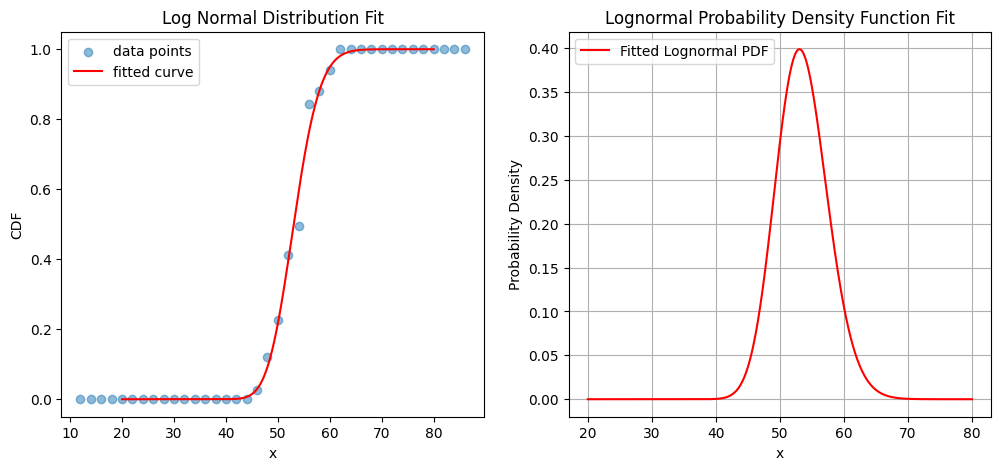

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# CDF Plot
x_vals = np.linspace(20, 80, 500)
y_fit_curve = lognormal_cdf(x_vals, mu_fit, sigma_fit)
ax1.scatter(x_filtered, y_filtered, label='data points', alpha=0.5)
ax1.plot(x_vals, y_fit_curve, 'r-', label='fitted curve')
ax1.set_xlabel('x')
ax1.set_ylabel('CDF')
ax1.legend()
ax1.set_title('Log Normal Distribution Fit')
# PDF Plot
x_pdf = np.linspace(20, 80, 500)
y_pdf = norm.pdf((np.log(x_pdf) - mu_fit) / sigma_fit)
ax2.plot(x_pdf, y_pdf, label='Fitted Lognormal PDF', color='red')
ax2.set_title('Lognormal Probability Density Function Fit')
ax2.set_xlabel('x')
ax2.set_ylabel('Probability Density')
ax2.legend()
ax2.grid(True)
plt.show()